In [1]:
import pandas as pd
import numpy as np

ONLY_ORGANIC = True
name = 'equal_prop_species_division'

predictions = pd.read_csv(f'results/{name}_only_organic_predictions.csv' if ONLY_ORGANIC else f'results/{name}_predictions.csv')
predictions_embedding = pd.read_csv(f'results/{name}_only_organic_predictions_embedding.csv' if ONLY_ORGANIC else f'results/{name}_predictions_embedding.csv')

In [2]:
chemical_entity_mappings = pd.read_pickle('only_organic_chemical_entity_mappings.pkl' if ONLY_ORGANIC else 'chemical_entity_mappings.pkl')
species_entity_mappings = pd.read_pickle('only_organic_species_entity_mappings.pkl' if ONLY_ORGANIC else 'species_entity_mappings.pkl')

chemical_entity_mappings = {int(i):str(k) for k,i in chemical_entity_mappings.items()}
species_entity_mappings = {int(i):str(k) for k,i in species_entity_mappings.items()}

In [3]:
predictions['chemical'] = [chemical_entity_mappings[c] for c in predictions['chemical']]
predictions['species'] = [species_entity_mappings[c] for c in predictions['species']]
predictions_embedding['chemical'] = [chemical_entity_mappings[c] for c in predictions_embedding['chemical']]
predictions_embedding['species'] = [species_entity_mappings[c] for c in predictions_embedding['species']]

In [4]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
namespace = 'https://cfpub.epa.gov/ecotox/'

endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?cas ?mw where {
  ?c wdt:P231 ?castmp ;
     wdt:P2067 ?mw .
  bind(replace(?castmp,'-','') as ?cas)
}"""

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

mw = {}
for result in results["results"]["bindings"]:
    mw['https://cfpub.epa.gov/ecotox/cas/'+result['cas']['value']] = float(result['mw']['value'])


In [5]:
predictions['molecular_weight'] = [mw[c] for c in predictions['chemical']]
predictions_embedding['molecular_weight'] = [mw[c] for c in predictions_embedding['chemical']]

In [6]:
def mw_convertions(w,x):
    out = w * 10**(-x) * 1e3
    return out

predictions['predicted conc (mg/L)'] = mw_convertions(predictions['molecular_weight'],predictions['prediction'])
predictions_embedding['predicted conc (mg/L)'] = mw_convertions(predictions_embedding['molecular_weight'],predictions_embedding['prediction'])

predictions['true conc (mg/L)'] = mw_convertions(predictions['molecular_weight'], predictions['true'])
predictions_embedding['true conc (mg/L)'] = mw_convertions(predictions_embedding['molecular_weight'],predictions_embedding['true'])

In [7]:
def hazard_function(c):
    if np.isnan(c): 
        return 'NaN'
    if c <= 1: #mg/L
        return 'Category 1' # Very toxic
    if c <= 10:
        return 'Category 2' # Toxic
    if c <= 100:
        return 'Category 3' # Harmful
    return 'Category 4' # Maybe harmful

predictions['predicted hazard'] = list(map(hazard_function,predictions['predicted conc (mg/L)'].values))
predictions_embedding['predicted hazard'] = list(map(hazard_function,predictions_embedding['predicted conc (mg/L)'].values))
predictions['true hazard'] = list(map(hazard_function,predictions['true conc (mg/L)'].values))
predictions_embedding['true hazard'] = list(map(hazard_function,predictions_embedding['true conc (mg/L)'].values))


In [8]:
mapping = {'Category 1':0,'Category 2':1,'Category 3':2,'Category 4':3}

In [9]:
from sklearn.preprocessing import LabelEncoder
def cat_accuracy(true,predicted):
    true = np.asarray(list(map(lambda x: mapping[x],true)))
    predicted = np.asarray(list(map(lambda x: mapping[x],predicted)))
    r = 1 + abs(true-predicted)
    return np.mean(1/r)

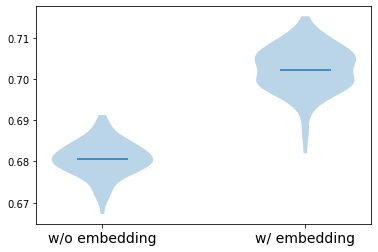

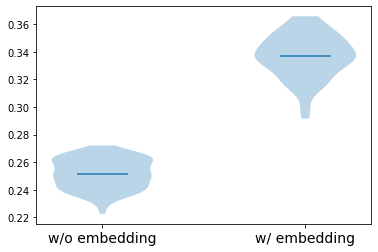

In [10]:
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt

scores = []
r2 = []

N=100

for i in range(N):
    r = pd.read_csv(f'results/{name}_seed_{i}_only_organic_predictions.csv' if ONLY_ORGANIC else f'results/{name}_seed_{i}_predictions.csv')
    re = pd.read_csv(f'results/{name}_seed_{i}_only_organic_predictions_embedding.csv' if ONLY_ORGANIC else f'results/{name}_seed_{i}_predictions_embedding.csv')
    
    molecular_weight = np.asarray(list(map(lambda x: mw[chemical_entity_mappings[x]],r['chemical'])))
    
    r['true conc (mg/L)'] = mw_convertions(molecular_weight,r['true'].values)
    re['true conc (mg/L)'] = mw_convertions(molecular_weight,re['true'].values)
    
    r['predicted conc (mg/L)'] = mw_convertions(molecular_weight,r['prediction'].values)
    re['predicted conc (mg/L)'] = mw_convertions(molecular_weight,re['prediction'].values)
    
    r['true hazard'] = list(map(hazard_function,r['true conc (mg/L)'].values))
    re['true hazard'] = list(map(hazard_function,re['true conc (mg/L)'].values))
    
    r['predicted hazard'] = list(map(hazard_function,r['predicted conc (mg/L)'].values))
    re['predicted hazard'] = list(map(hazard_function,re['predicted conc (mg/L)'].values))
    
    s = cat_accuracy(r['true hazard'],r['predicted hazard'])
    se = cat_accuracy(re['true hazard'],re['predicted hazard'])
    
    scores.append([s,se])
    r2.append([r2_score(r['true'],r['prediction']),r2_score(re['true'],re['prediction'])])
    
s,se = np.split(np.asarray(scores),2,axis=1)
fig, ax = plt.subplots()

plt.violinplot(np.asarray(scores),[0,1],
              showmeans=True, showmedians=False,
                showextrema=False)

plt.xticks([0.0,1.0], ['w/o embedding','w/ embedding'],fontsize=14)

plt.savefig(f'results/{name}_only_organic_predictions_cat_accuracy.png' if ONLY_ORGANIC else f'results/{name}_predictions_cat_accuracy.png')
plt.show()
plt.close()

s,se = np.split(np.asarray(r2),2,axis=1)
fig, ax = plt.subplots()

plt.violinplot(np.asarray(r2),[0,1],
              showmeans=True, showmedians=False,
                showextrema=False)
plt.xticks([0.0,1.0], ['w/o embedding','w/ embedding'],fontsize=14)

plt.savefig(f'results/{name}_only_organic_predictions_r2.png' if ONLY_ORGANIC else f'results/{name}_predictions_r2.png')
plt.show()

In [11]:
from rdflib import Graph, URIRef, Literal
import numpy as np
import glob 

chemical_graph = Graph()
for filename in glob.glob('only_organic_reduced_kgs/reduced_chembl*' if ONLY_ORGANIC else 'reduced_kgs/reduced_chembl*'):
    chemical_graph.load(filename,format=filename.split('.')[-1])
chemical_graph.load('only_organic_reduced_kgs/reduced_chebi.ttl' if ONLY_ORGANIC else 'reduced_kgs/reduced_chebi.ttl',format='ttl')
#chemical_graph.load('only_organic_reduced_kgs/reduced_mesh.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_mesh.nt',format='nt')
chemical_graph.load('only_organic_physical_properties.ttl' if ONLY_ORGANIC else 'physical_properties.ttl',format='ttl')

species_graph = Graph()
species_graph.load('only_organic_reduced_kgs/reduced_taxonomy.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_taxonomy.nt',format='nt')
species_graph.load('only_organic_reduced_kgs/reduced_traits.nt' if ONLY_ORGANIC else 'reduced_kgs/reduced_traits.nt',format='nt')


chemical_entities = sorted(list(set(chemical_graph.subjects()) | set(chemical_graph.objects())))
chemical_relations = sorted(list(set(chemical_graph.predicates())))

species_entities = sorted(list(set(species_graph.subjects()) | set(species_graph.objects())))
species_relations = sorted(list(set(species_graph.predicates())))


chemical_entity_mappings = {e:i for i,e in enumerate(chemical_entities)}
chemical_relation_mappings = {e:i for i,e in enumerate(chemical_relations)}

species_entity_mappings = {e:i for i,e in enumerate(species_entities)}
species_relation_mappings = {e:i for i,e in enumerate(species_relations)}


In [12]:
#add geonames
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib.namespace import RDFS
endpoint_url = "https://query.wikidata.org/sparql"

query = """select ?id ?label where {
  ?place wdt:P1566 ?id ;
         wdt:P1448 ?label .
  
   filter(lang(?label) = 'en')
}"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    species_graph.add((URIRef('http://www.geonames.org/'+result['id']['value']),RDFS.label,Literal(result['label']['value'])))

In [13]:
entity_matrix = [np.load(f'organic_only_W_{i}.npy' if ONLY_ORGANIC else f'W_{i}.npy') for i in range(2)]

In [14]:
species = set(predictions.species)
chemicals = set(predictions.chemical)

In [15]:
%%time
import tqdm.notebook as tq
from itertools import product
from scipy.spatial import distance

lf = lambda x,y: np.linalg.norm(x-y,ord=2)

distance_matrix_chemicals = np.asarray([lf(entity_matrix[0][chemical_entity_mappings[URIRef(c1)]],entity_matrix[0][chemical_entity_mappings[URIRef(c2)]]) for c1,c2 in tq.tqdm(product(chemicals,chemicals),total=len(chemicals)**2)]).reshape((len(chemicals),len(chemicals)))
distance_matrix_species = np.asarray([lf(entity_matrix[1][species_entity_mappings[URIRef(s1)]],entity_matrix[1][species_entity_mappings[URIRef(s2)]]) for s1,s2 in tq.tqdm(product(species,species),total=len(species)**2)]).reshape((len(species),len(species)))


CPU times: user 1.33 s, sys: 245 ms, total: 1.58 s
Wall time: 1.31 s


In [16]:
distance_matrix_species.shape

(225, 225)

In [17]:
species_mappings = {k:i for i,k in enumerate(species)}
chemical_mappings = {k:i for i,k in enumerate(chemicals)}
inverse_species_mappings = {i:k for i,k in enumerate(species)}
inverse_chemical_mappings = {i:k for i,k in enumerate(chemicals)}

In [18]:
def label_obo(uri):
    
    query = """
            prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
            prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> 
            prefix owl: <http://www.w3.org/2002/07/owl#> 

            SELECT distinct ?label WHERE { 
                <%s> rdfs:label ?label .
            }
            """ % str(uri)
    results = get_results('http://sparql.hegroup.org/sparql/', query)
    return results
    
def mesh_label(uri):
    
    query = """
            prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> 
            prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>
            prefix owl: <http://www.w3.org/2002/07/owl#> 

            SELECT distinct ?label WHERE { 
                <%s> rdfs:label ?label .
            }
            """ % str(uri)
    
    return get_results('http://id.nlm.nih.gov/mesh/sparql',query)


In [19]:
full_taxonomy = Graph()
full_taxonomy.load('only_organic_reduced_kgs/taxonomy.nt' if ONLY_ORGANIC else 'reduced_kgs/taxonomy.nt',format='nt')
full_taxonomy += species_graph


In [20]:

def taxon_name(uri):
    try:
        return str(list(full_taxonomy.objects(subject=URIRef(uri),predicate=URIRef('https://cfpub.epa.gov/ecotox/latinName'))).pop(0))
    except:
        pass
    try:
        return str(list(full_taxonomy.objects(subject=URIRef(uri),predicate=RDFS.label)).pop(0))
    except:
        pass
    
    try:
        if 'obo' in str(uri):
            for res in label_obo(uri)['results']['bindings']:
                return str(res['label']['value'])
    except:
        pass
     
    return uri
    
def chemical_name(uri):
    try:
        l = list(chemical_graph.objects(subject=URIRef(uri),predicate=RDFS.label))
        return str(l.pop(0)).split('/')[-1]
    except:
        pass
    
    if 'mesh' in str(uri):
        for res in mesh_label(uri)['results']['bindings']:
            return str(res['label']['value'])
    
        
    return uri
    

In [21]:
import sys
from collections import defaultdict
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def wikidata_explanation(list_of_uris):
    
    query = """select ?cas ?p ?o where {
                  values ?cas {%s}
                  ?chem wdt:P231 ?castmp ;
                          ?p ?o .
                  bind (replace(?castmp,"-","") as ?cas)
                  filter (!isLiteral(?o))
                }""" % ' '.join(map(lambda x: '\"' + x.split('/')[-1] + '\"',list_of_uris))

    d = defaultdict(set)
    
    results = get_results(endpoint_url, query)

    for result in results["results"]["bindings"]:
        d[result['cas']['value']].add((result['p']['value'],result['o']['value']))
    
    return set.intersection(*[d[k] for k in d])


In [22]:
predictions_embedding['categorical error'] = [abs(int(true.split()[-1])-int(pred.split()[-1])) for true,pred in zip(predictions_embedding['true hazard'].values,predictions_embedding['predicted hazard'].values)]
predictions_embedding['log-mae (mol/L)'] = abs(predictions_embedding['true']- predictions_embedding['prediction'])

In [23]:
predictions_embedding.sort_values(by='log-mae (mol/L)',axis=0,inplace=True,ascending=False)

In [24]:
n = 11
out = []
for i,row in enumerate(predictions_embedding[predictions_embedding['true hazard'] != 'Category 4'].iterrows()):
    
    true_haz = row[1]['true hazard']
    pred_haz = row[1]['predicted hazard']
    
    exp_species = np.argsort(distance_matrix_species[species_mappings[row[1]['species']]])[:n+1]
    exp_chemical = np.argsort(distance_matrix_chemicals[chemical_mappings[row[1]['chemical']]])[:n+1]
 
    tn = taxon_name(row[1]['species'])
    cn = chemical_name(row[1]['chemical'])
    
    #print(f'True hazard: {true_haz}, predicted: {pred_haz}. log-mae (mol/L):',row[1]['log-mae (mol/L)'])
    
    #print(f'Prediction chemical: {cn}, species: {tn}')
    
    sp = [URIRef(inverse_species_mappings[i]) for i in exp_species]
    cp = [URIRef(inverse_chemical_mappings[i]) for i in exp_chemical]
    
    explanation_s = set.intersection(*[set(species_graph.predicate_objects(subject=s)) for s in sp])
    explanation_c = set.intersection(*[set(chemical_graph.predicate_objects(subject=c)) for c in cp])
    
    #explanation_s = wikidata_explanation(map(str,sp))
    #explanation_c = wikidata_explanation(map(str,cp))
    
    #print('Explanation')
    #print('Close species common facts:\n','\t'+'\n\t'.join(map(lambda x: ', '.join(map(taxon_name,x)),explanation_s)))
    #print('Close compound common facts:\n','\t'+'\n\t'.join(map(lambda x: ', '.join(map(chemical_name,x)),explanation_c)))
    
    out.append((len(explanation_c),len(explanation_s),row[1]['log-mae (mol/L)']))
    
    #print(f'{tn} close to',[taxon_name(inverse_species_mappings[i]) for i in exp_species])
    #print(f'{cn} close to',[chemical_name(inverse_chemical_mappings[i]) for i in exp_chemical])
    #print('')
    
    #if i > 0.5*len(predictions_embedding): break

In [25]:
out = np.asarray(out)
xc,xs,y = np.split(np.asarray(out),3,axis=-1)
xc = xc.ravel()
xs = xs.ravel()
y = y.ravel()

In [26]:
import scipy as sp
sp.stats.pearsonr(xc,y.ravel()),sp.stats.pearsonr(xs.ravel(),y.ravel())

((-0.08058461171017528, 0.1428752623432565),
 (-0.13210691151200582, 0.016014306226710663))

In [27]:
from sklearn.metrics import r2_score

r2_score(predictions['true'], predictions['prediction']),r2_score(predictions_embedding['true'], predictions_embedding['prediction'])

(0.26023922495526197, 0.3522419856626896)

In [28]:
cat_accuracy(predictions['true hazard'],predictions['predicted hazard']),cat_accuracy(predictions_embedding['true hazard'],predictions_embedding['predicted hazard'])

(0.6789537712895377, 0.7017031630170316)

In [29]:
def category_difference(t,p):
    t = map(lambda x: int(x.split()[-1]), t)
    p = map(lambda x: int(x.split()[-1]), p)
    
    return np.asarray(list(t)) - np.asarray(list(p))
    

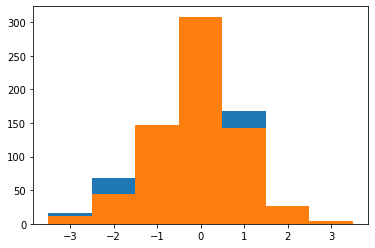

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(category_difference(predictions['true hazard'],predictions['predicted hazard']),bins=[-3.5,-2.5,-1.5,-.5,.5,1.5,2.5,3.5])
plt.hist(category_difference(predictions_embedding['true hazard'],predictions_embedding['predicted hazard']),bins=[-3.5,-2.5,-1.5,-.5,.5,1.5,2.5,3.5])
pass

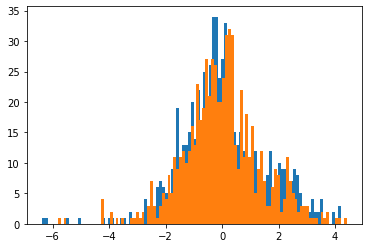

In [31]:
plt.hist((predictions['true']-predictions['prediction']),bins=100)
plt.hist((predictions_embedding['true']-predictions_embedding['prediction']),bins=100)
pass

In [32]:
from rdflib.plugins.sparql import prepareQuery
from rdflib.namespace import RDF
def data_density(data,neighbors,key):
    return sum(data[key].isin(set(map(str,neighbors))).values)/len(set(neighbors))

def neighborhood_density(graph,data,uri,depth=1,key='species'):
    
    q = """
        select ?p where {
            <%s> rdf:type / rdfs:subClassOf ?p .
        }
    """ % str(uri)
    q = prepareQuery(q,initNs={'rdf':RDF,'rdfs':RDFS})
    
    try:
        parent = list(filter(lambda x: '/taxon/' in str(x), map(lambda x:x[0],graph.query(q))))[0]
    except:
        return 0.0
    
    q = """
        select ?s where {
            ?s rdf:type / rdfs:subClassOf <%s> .
        }
    """ % str(parent)
    q = prepareQuery(q,initNs={'rdf':RDF,'rdfs':RDFS})
    
    neighbors = set(filter(lambda x: '/taxon/' in str(x), map(lambda x:x[0],graph.query(q))))
    
    return data_density(data,neighbors,key)    


def neighborhood_density2(graph,uri,depth=1):
    
    neighbors = set([uri])

    while depth > 0:
        neighbors |= set.union(*list(map(lambda n: set(graph.objects(subject=n)),neighbors)))
        depth -= 1
        neighbors = set(filter(lambda x: not isinstance(x,Literal),neighbors))
                               
    l = set.union(*list(map(lambda p: set(graph.objects(subject=URIRef(p))),neighbors)))
    l = set(filter(lambda x: not isinstance(x,Literal),l))
    
    return len(l)
    

In [33]:
n = 10
out = []

new_idx = defaultdict(lambda : -1)
j = 0
for i,row in tq.tqdm(enumerate(predictions_embedding.iterrows()),total=len(predictions_embedding)):
    
    true_haz = row[1]['true hazard']
    pred_haz = row[1]['predicted hazard']
    
    exp_species = distance_matrix_species[species_mappings[row[1]['species']]]
    exp_chemical = distance_matrix_chemicals[chemical_mappings[row[1]['chemical']]]

    out.append(np.concatenate([[row[1]['log-mae (mol/L)']],exp_chemical,exp_species],axis=-1))
    

In [34]:
out = np.asarray(out)

yc = out[:,0]
x = out[:,1:]

In [35]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

t = np.zeros(x.shape[1])
scores = []

for i in range(100):
    m = RandomForestRegressor()

    xtr,xte,ytr,yte = train_test_split(x,yc,test_size=0.2)

    m.fit(xtr,ytr)
    #t += m.feature_importances_
    scores.append(mean_absolute_error(m.predict(xte),yte))
    
np.mean(scores),np.std(scores)

(0.5927431655728076, 0.04566003228880807)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

f = lambda x: abs(float(x[0].split()[-1])-float(x[1].split()[-1]))

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    return heatmap.T, extent


c_range = (xc.min(),xc.max()+1)
s_range = (xs.min(),xs.max()+1)

des = [0.0,1.0,2.0,3.0]

X = -1 * np.ones((*c_range, *s_range)).squeeze()

for d in des:
    j = np.where(predictions_embedding['categorical error'].values==d)[0]
    j = list(filter(lambda x: x>=0, j))
    
    X[xc[j],xs[j]] = predictions_embedding['categorical error'].values[j]
    
color_map = {0.0: np.array([0, 255, 0]), #green
             1.0: np.array([0, 0, 255]), # blue
             2.0: np.array([255, 0, 0]), # red
             3.0: np.array([0, 0, 0]),# black 
            -1.0: np.array([255, 255, 255])} # white 

mask = X == -1
rows = np.flatnonzero((~mask).sum(axis=1))
cols = np.flatnonzero((~mask).sum(axis=0))

old_ticks = X.shape

X = X[rows, :][:,cols]

new_ticks = X.shape

# make a 3d numpy array that has a color channel dimension   
data_3d = np.ndarray(shape=(X.shape[0], X.shape[1], 3), dtype=int)
for i in range(0, X.shape[0]):
    for j in range(0, X.shape[1]):
        data_3d[i][j] = color_map[X[i][j]]

# display the plot 
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(data_3d)
fig.canvas.draw()
labels = [item.get_text() for item in ax.get_xticklabels()]
ax.set_xticklabels(np.linspace(0,old_ticks[0],len(labels),dtype=int))

labels = [item.get_text() for item in ax.get_yticklabels()]
ax.set_yticklabels(np.linspace(0,old_ticks[1],len(labels),dtype=int))

plt.xlabel('# chemical neighbours',fontsize=20)
plt.ylabel('# species neighbours',fontsize=20)

plt.show()

TypeError: 'numpy.float64' object cannot be interpreted as an integer

In [ ]:
r1 = 9
r2 = 11

out = []

new_idx = defaultdict(lambda : -1)
j = 0
for i,row in tq.tqdm(enumerate(predictions_embedding.iterrows()),total=len(predictions_embedding)):
        
    true_haz = row[1]['true hazard']
    pred_haz = row[1]['predicted hazard']
    
    exp_species = distance_matrix_species[species_mappings[row[1]['species']]]
    exp_chemical = distance_matrix_chemicals[chemical_mappings[row[1]['chemical']]]

    #nds = sum(np.where(exp_species<r1,1,0))
    #ndc = sum(np.where(exp_chemical<r2,1,0))

    nds = neighborhood_density2(full_taxonomy,URIRef(row[1]['species']),depth=r1)
    ndc = neighborhood_density2(chemical_graph,URIRef(row[1]['chemical']),depth=r2)
    
    out.append([row[1]['categorical error'],nds,ndc])
    
    new_idx[i] = j
    j += 1

In [ ]:
y,xs,xc = np.split(np.asarray(out),3,axis=-1)
x = np.concatenate([xs,xc],axis=1)
y,xc,xs = map(lambda x: x.ravel(),[y,xc,xs])

fig, axs = plt.subplots(1,2)
for z,ax in zip([xc,xs],axs):
    ax.hist(z,bins=10)
    ax.set_yscale('log')

pass

In [ ]:

out = np.asarray(out)

yc = out[:,0]
x = out[:,1:]
xc,xs = x[:,0],x[:,1]

s = 3
des = [0.0,1.0,2.0,3.0]

xlim = (50,280)
ylim = (20,200)

chosen_value = 20
fig, axs = plt.subplots(2,2, figsize=(chosen_value, 1.5 * chosen_value / 2),
                               subplot_kw={'aspect': 1})

for i, ax in enumerate(axs.flatten()):
    
    j = np.where(predictions_embedding['categorical error'].values==des[i])[0]
    j = list(filter(lambda x: (xs[x]>xlim[0] and xs[x]<xlim[1]) and (xc[x]<ylim[1] and xc[x]>ylim[0]),j))
    
    img, extent = myplot(xs[j], xc[j], s, bins=100)
    im = ax.imshow(img, extent=extent, origin='lower', cmap=cm.jet,aspect="auto")
    
    ax.set_title("Category error = %s" % int(des[i]) + " (#=%s)" % int(len(j)), fontsize=20)
    ax.set_ylabel(f'Chemical neighbours, depth={r2}', fontsize=20)
    ax.set_xlabel(f'Species neighbours, depth={r1}', fontsize=20)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.savefig(f'results/{name}_only_organic_temp_plot.png' if ONLY_ORGANIC else f'results/{name}_temp_plot.png')
plt.show()

In [ ]:
import scipy as sp
sp.stats.pearsonr(xc,y.ravel()),sp.stats.pearsonr(xs.ravel(),y.ravel())